In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [7]:
df = pd.read_csv("bubble-size-distribution-5-rounds.csv").set_index("bubble size").div(100).fillna(0)
df = df[[x for x in df.columns if int(x)>=32]]
df

,32,33,34,35,36,37,38,39,40,41,42,43,44,45
bubble size,,,,,,,,,,,,,,
0,0.137,0.257,0.268,0.392,0.394,0.459,0.459,0.440,0.437,0.387,0.382,0.369,0.367,0.414
1,0.014,0.046,0.045,0.117,0.118,0.226,0.228,0.339,0.340,0.358,0.360,0.296,0.294,0.213
2,0.001,0.003,0.003,0.011,0.012,0.037,0.038,0.092,0.095,0.184,0.185,0.248,0.250,0.223
3,0.003,0.000,0.000,0.000,0.000,0.003,0.002,0.009,0.009,0.031,0.030,0.071,0.073,0.127
4,0.019,0.003,0.003,0.000,0.001,0.000,0.000,0.001,0.000,0.002,0.002,0.008,0.008,0.021
5,0.095,0.017,0.020,0.002,0.003,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.002
6,0.261,0.080,0.084,0.014,0.017,0.002,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.000
7,0.315,0.199,0.204,0.057,0.059,0.011,0.010,0.001,0.001,0.000,0.000,0.000,0.000,0.000
8,0.155,0.277,0.267,0.141,0.144,0.036,0.037,0.005,0.006,0.001,0.001,0.000,0.000,0.000


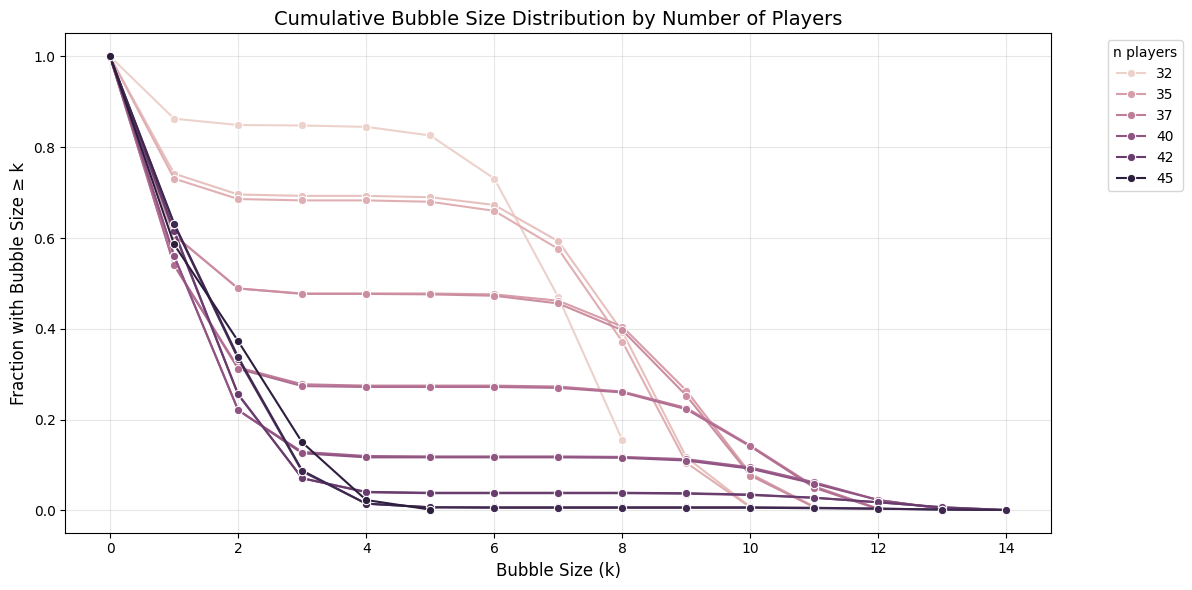

In [8]:
# Prepare data for visualization
# df has "bubble size" as index, and columns 32, 33, 34, ... are player counts
# Reset index to make bubble size a column, then melt
df_plot = df.reset_index()
df_plot = df_plot.melt(id_vars=['bubble size'], var_name='n players', value_name='proportion')

# Convert 'n players' to integer for proper sorting
df_plot['n players'] = df_plot['n players'].astype(int)
# Ensure bubble size is integer
df_plot['bubble size'] = df_plot['bubble size'].astype(int)

# Calculate cumulative proportions: fraction with bubble size >= k
# Sort by bubble size in descending order, then calculate cumulative sum, then reverse
df_cumulative = df_plot.copy()
df_cumulative = df_cumulative.sort_values(['n players', 'bubble size'], ascending=[True, False])
df_cumulative['cumulative_proportion'] = df_cumulative.groupby('n players')['proportion'].cumsum()
df_cumulative = df_cumulative.sort_values(['n players', 'bubble size'], ascending=[True, True])

# Filter out trailing zeros: for each player count, keep only up to the last non-zero cumulative proportion
df_cumulative_filtered = []
for n_players in df_cumulative['n players'].unique():
    subset = df_cumulative[df_cumulative['n players'] == n_players].copy()
    # Find the last index where cumulative_proportion > 0 (or very close to 0)
    last_nonzero_idx = subset[subset['cumulative_proportion'] > 1e-6].index
    if len(last_nonzero_idx) > 0:
        # Keep all rows up to and including the last non-zero one
        subset_filtered = subset.loc[:last_nonzero_idx[-1]]
        df_cumulative_filtered.append(subset_filtered)
    else:
        # If all zeros, keep just the first row
        df_cumulative_filtered.append(subset.iloc[:1])

df_cumulative_filtered = pd.concat(df_cumulative_filtered)

# Create cumulative line plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_cumulative_filtered, x='bubble size', y='cumulative_proportion', hue='n players', marker='o')
plt.xlabel('Bubble Size (k)', fontsize=12)
plt.ylabel('Fraction with Bubble Size ≥ k', fontsize=12)
plt.title('Cumulative Bubble Size Distribution by Number of Players', fontsize=14)
plt.legend(title='n players', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [9]:
# Calculate mean and median bubble size for each n players
summary_stats = []

for col in df.columns:
    proportions = df[col].values
    bubble_sizes = df.index.astype(int).values
    
    # Mean: weighted average
    mean_bubble_size = np.average(bubble_sizes, weights=proportions)
    
    # Median: find bubble size where cumulative proportion reaches 0.5
    cumulative = np.cumsum(proportions)
    median_idx = np.searchsorted(cumulative, 0.5)
    median_bubble_size = bubble_sizes[median_idx] if median_idx < len(bubble_sizes) else bubble_sizes[-1]
    
    # Fraction with bubble size >= 5
    fraction_ge_5 = np.sum(proportions[bubble_sizes >= 5])
    
    summary_stats.append({
        'n players': col,
        'Mean Bubble Size': mean_bubble_size,
        'Median Bubble Size': median_bubble_size,
        'Fraction with Bubble >= 5': fraction_ge_5
    })

summary_df = pd.DataFrame(summary_stats)
summary_df = summary_df.set_index('n players').drop(["n players", "bubble size"], errors='ignore')
summary_df


,Mean Bubble Size,Median Bubble Size,Fraction with Bubble >= 5
n players,,,
32,5.587000,6,0.826
33,5.304304,7,0.690
34,5.188188,7,0.680
35,4.233467,1,0.478
36,4.184815,1,0.476
37,2.920000,1,0.275
38,2.891892,1,0.272
39,1.802000,1,0.119
40,1.783567,1,0.117
